## 查看像素值

In [17]:
import SimpleITK as sitk
import numpy as np

folder_path = '/workspace/data/579/POPI_seq3_579/4DCT-Dicom4/70'

# 使用SimpleITK的ImageSeriesReader读取DICOM序列
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(folder_path)
reader.SetFileNames(dicom_names)
image = reader.Execute()
image_array = sitk.GetArrayFromImage(image)

min_val = image_array.min()
max_val = image_array.max()
print("最小画素值:", min_val)
print("最大画素值:", max_val)

最小画素值: -1024
最大画素值: 2976


In [4]:
from skimage import io
# Load the new image
image_path = "/workspace/data/Overlap/SSIM&MAE/SMPurple_Mask_Patient5_GT5.png"
new_image = io.imread(image_path)

# Find the minimum and maximum pixel values
min_pixel_value = new_image.min()
max_pixel_value = new_image.max()

print("最小画素值:", min_pixel_value)
print("最大画素值:", max_pixel_value)

最小画素值: 0
最大画素值: 239


## SSIM and MAE

In [26]:
from skimage.metrics import structural_similarity as ssim
from skimage.io import imread
import numpy as np

# Load images
# image1 = imread('/workspace/data/Overlap/SSIM&MAE/SMGreen_Mask_Patient5_GT5.png', as_gray=True)
# image2 = imread('/workspace/data/Overlap/SSIM&MAE/SMPurple_Mask_Patient5_GT5.png', as_gray=True)
image1 = imread('/workspace/data/Overlap/SSIM&MAE/Patient2_GT5_Dark.png', as_gray=True)
image2 = imread('/workspace/data/Overlap/SSIM&MAE/Patient2_GT5_Light.png', as_gray=True)

# Ensure images are the same size
if image1.shape != image2.shape:
    raise ValueError("Images must have the same dimensions.")

# Determine data range based on the type of the image
data_range = image1.max() - image1.min()

# Calculate SSIM
ssim_index = ssim(image1, image2, data_range=data_range)

# Calculate MAE
mae_score = np.mean(np.abs(image1.astype("float") - image2.astype("float")))

ssim_index, mae_score

(0.1605987996047465, 0.4188442770453027)

In [25]:
# MAE
from skimage import io
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Load the images
# image1 = imread("/workspace/data/Overlap/SSIM&MAE/SMGreen_Mask_Patient5_GT5.png")
# image2 = imread("/workspace/data/Overlap/SSIM&MAE/SMPurple_Mask_Patient5_GT5.png")
image1 = imread("/workspace/data/Overlap/SSIM&MAE/Patient2_GT5_Light.png")
image2 = imread("/workspace/data/Overlap/SSIM&MAE/Patient2_GT5_Dark.png")

# Compute MAE
mae_score = np.mean(np.abs(image1.astype(np.float64) - image2.astype(np.float64)))
mae_score

106.80529064655218

In [31]:
from skimage import io
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Load the images
image1 = imread("/workspace/data/Overlap/SSIM&MAE/SMGreen_Mask_Patient5_GT5.png")
image2 = imread("/workspace/data/Overlap/SSIM&MAE/SMPurple_Mask_Patient5_GT5.png")
# image1 = imread("/workspace/data/Overlap/SSIM&MAE/Patient2_GT5.png")
# image2 = imread("/workspace/data/Overlap/SSIM&MAE/Patient2_GT5_Dark.png")

# Convert images to grayscale if they are not already
if image1.ndim == 3:
    image1 = image1[:, :, 0]
if image2.ndim == 3:
    image2 = image2[:, :, 0]

# Compute SSIM
ssim_index = ssim(image1, image2)

# Compute MAE
mae_value = np.mean(np.abs(image1.astype(np.float64) - image2.astype(np.float64)))
print("SSIM:", ssim_index)
print("MAE:", mae_value)

SSIM: 0.011160060873791282
MAE: 38.15815155784857


## Masked

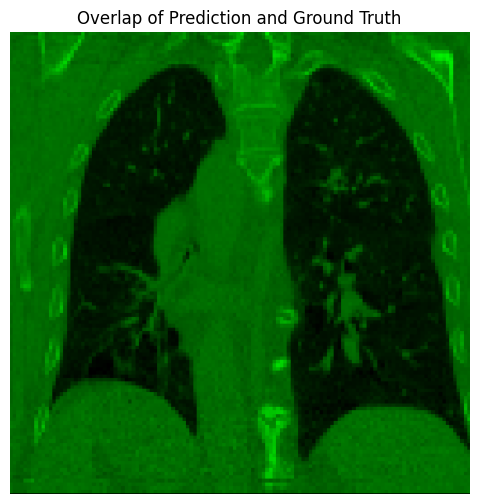

In [9]:
# Green
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load the image
img_path = '/workspace/data/Overlap/SSIM&MAE/Patient2_GT5.png'
img = Image.open(img_path).convert('L')  # Convert to grayscale

# Create a mask where the grayscale values are converted to green
img_array = np.array(img)
green_mask = np.zeros((img_array.shape[0], img_array.shape[1], 3), dtype=np.uint8)
green_mask[:, :, 1] = img_array  # Set the green channel to the image values

# Convert back to image
green_mask_img = Image.fromarray(green_mask)

# Save the green mask image
output_path = '/workspace/data/Overlap/SSIM&MAE/SMGreen_Mask_Patient5_GT5.png'
green_mask_img.save(output_path)
output_path

plt.figure(figsize=(6, 6))
plt.imshow(green_mask_img)
plt.title('Overlap of Prediction and Ground Truth')
plt.axis('off')
plt.show()

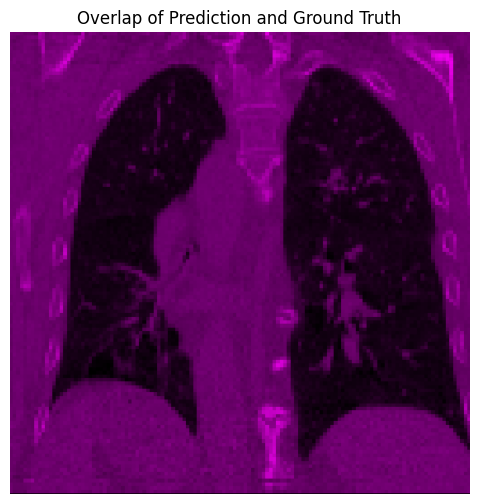

In [11]:
# Purple
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load the image
img_path = '/workspace/data/Overlap/SSIM&MAE/Patient2_GT5.png'
img = Image.open(img_path).convert('L')  # Convert to grayscale

# Create a mask where the grayscale values are converted to purple
img_array = np.array(img)
purple_mask = np.zeros((img_array.shape[0], img_array.shape[1], 3), dtype=np.uint8)
purple_mask[:, :, 0] = img_array  # Set the red channel
purple_mask[:, :, 2] = img_array  # Set the blue channel

# Convert back to image
purple_mask_img = Image.fromarray(purple_mask)

# Save the green mask image
output_path = '/workspace/data/Overlap/SSIM&MAE/SMPurple_Mask_Patient5_GT5.png'
purple_mask_img.save(output_path)

plt.figure(figsize=(6, 6))
plt.imshow(purple_mask_img)
plt.title('Overlap of Prediction and Ground Truth')
plt.axis('off')
plt.show()

## BOX PLOT

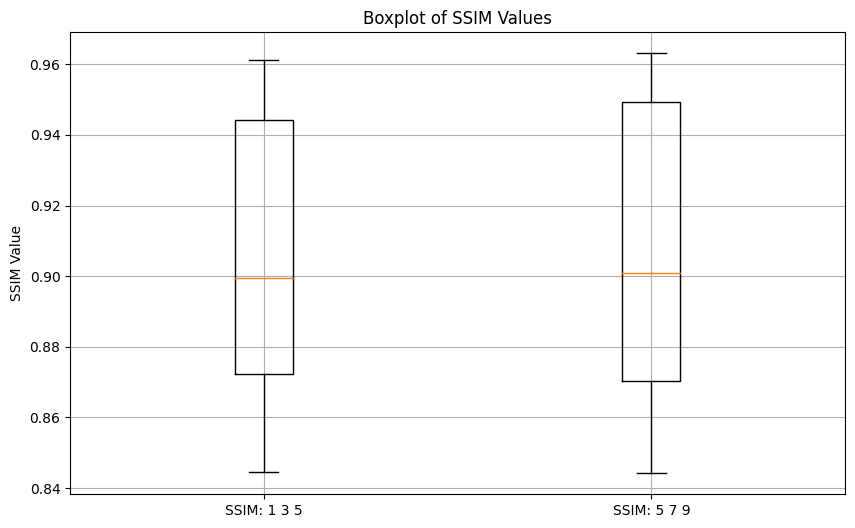

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# First we create a DataFrame from the data provided in the image.
data = {
    'Fold': [1, 2, 3, 4, 5, 6],
    'SSIM: 1 3 5': [0.8718, 0.8445, 0.9252, 0.8735, 0.9613, 0.9505],
    'SSIM: 5 7 9': [0.869, 0.8442, 0.9275, 0.8745, 0.9631, 0.9566],
    'SSIM: 0 2 4': [0.8915, 0.8354, 0.8908, 0.8893, 0.9577, 0.9545],
    'SSIM: 4 6 8': [0.881, 0.8587, 0.9158, 0.8995, 0.9537, 0.9583]
}

df = pd.DataFrame(data)
df.set_index('Fold', inplace=True)

# Now we plot the boxplot using the DataFrame
plt.figure(figsize=(10, 6))
plt.boxplot([df['SSIM: 1 3 5'], df['SSIM: 5 7 9']])
plt.xticks([1, 2], ['SSIM: 1 3 5', 'SSIM: 5 7 9'])
plt.title('Boxplot of SSIM Values')
plt.ylabel('SSIM Value')
plt.grid(True)
plt.show()

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
# First we create a DataFrame from the data provided in the image.
data = {
    'Fold': [1, 2, 3, 4, 5, 6],
    'SSIM: 1 3 5': [0.8915, 0.8354, 0.8908, 0.8893, 0.9577, 0.9545],
    'SSIM: 2 4 6': [0.8718, 0.8445, 0.9252, 0.8735, 0.9613, 0.9505],
    'SSIM: 5 7 9': [0.881, 0.8587, 0.9158, 0.8995, 0.9537, 0.9583],
    'SSIM: 6 8 10': [0.869, 0.8442, 0.9275, 0.8745, 0.9631, 0.9566]
}
df = pd.DataFrame(data)
df.set_index('Fold', inplace=True)

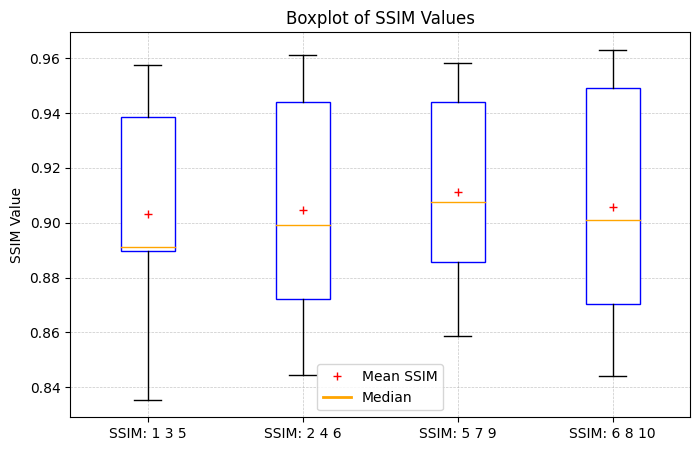

In [2]:
# Modify the provided code to replicate the style of the uploaded boxplot with a legend for the mean
plt.figure(figsize=(8, 5))

# Defining properties for the boxplot
boxprops = dict(linestyle='-', linewidth=1, color='blue')
meanpointprops = dict(marker='+', markeredgecolor='red', markerfacecolor='red')

# Creating the boxplot with mean points
boxplot_elements = plt.boxplot([df['SSIM: 1 3 5'], df['SSIM: 2 4 6'], df['SSIM: 5 7 9'], df['SSIM: 6 8 10']],
                               notch=False,
                               widths=0.35,
                               patch_artist=True,
                               showmeans=True,
                               meanprops=meanpointprops,
                               medianprops=dict(color="orange", linewidth=1), # median setting
                               boxprops=boxprops)

# Fill the boxes with color for better visual distinction
for patch in boxplot_elements['boxes']:
    patch.set_facecolor('white')

# Set the labels and titles
# plt.xticks([1, 3], ['SSIM: 1 3 5', 'SSIM: 5 7 9'])
plt.xticks(range(1, len(df.columns)+1), df.columns[0:])
# ['SSIM: 1 3 5', 'SSIM: 5 7 9', 'SSIM: 0 2 4', 'SSIM: 4 6 8']
plt.title('Boxplot of SSIM Values')
plt.ylabel('SSIM Value')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend for mean
plt.plot([], [], '+', color='red', label='Mean SSIM')
plt.plot([], [], color='orange', label='Median', linewidth=2)
plt.legend()

# Set the y-axis to start from 0
# plt.ylim(0.6,1)

# Show the plot with mean points indicated
plt.show()

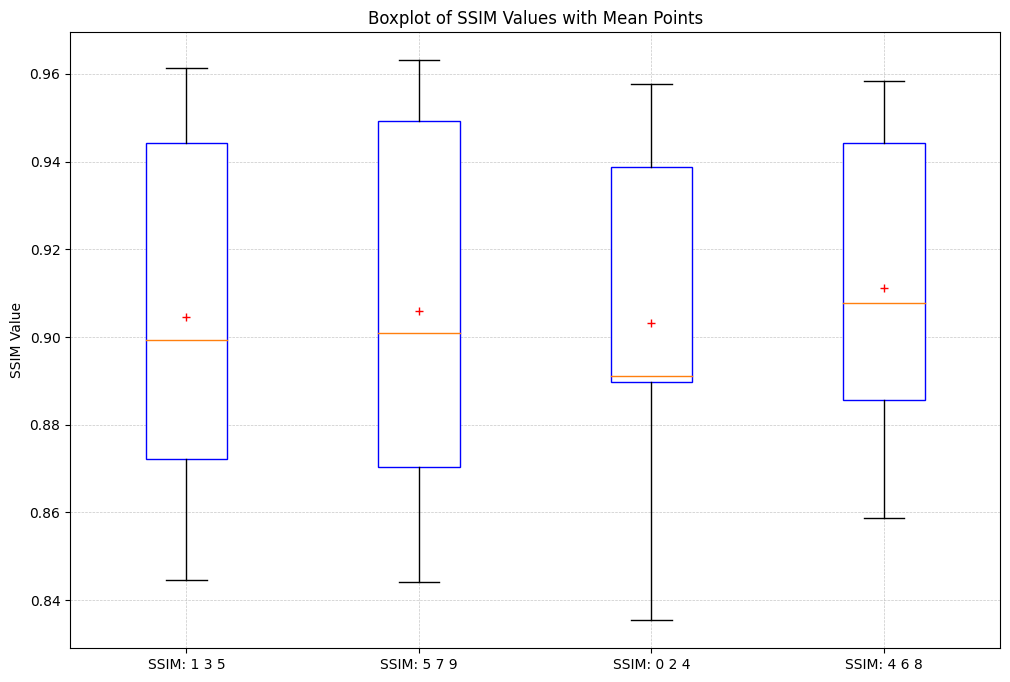

In [55]:
# Correcting the x-ticks to show all four columns of data
plt.figure(figsize=(12, 8))

# Creating the boxplot with mean points for the new data with all four columns
boxplot_elements = plt.boxplot([df[col] for col in df.columns],
                               notch=False,
                               widths=0.35,
                               patch_artist=True,
                               showmeans=True,
                               meanprops=meanpointprops,
                               boxprops=boxprops)

# Fill the boxes with color for better visual distinction
for patch in boxplot_elements['boxes']:
    patch.set_facecolor('white')

# Set the labels and titles with all four SSIM values
plt.xticks(range(1, len(df.columns) + 1), df.columns)
plt.title('Boxplot of SSIM Values with Mean Points')
plt.ylabel('SSIM Value')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)